# Basics about power measurements and Simple Power Analysis

You're about to take your first steps into measurement analysis. The aim of this first session is to make you discover side-channel analysis techniques from the very source: the measurement of a physical behaviors. It gives you the opportunity to see in practice what lies behind the term ‘physical side-channel’ and how analyses as trivial as a visual inspection can be the source of sensitive information. Beside, you'll see how to manipulate the datasets that we will use during the whole training. Apart giving you a more practical intuition about what a physical trace is, it will help you understand why advanced techniques are required, such as the one that will be covered in the others sessions. 


## Warmup - Attacking Password Authentication

For this first exercise, we're going to look at a very common practical example: verifying a PIN code. In simple terms, a naive strategy consists of checking the values one by one, returning an error if a difference is observed, and validating the PIN code if all the digits used match.

Let's now look at a situation in which we would have access to measurements of the physical behavior of a device applying such a procedure. More particularly, we take a look at the following 4-digit password verification code that, for now, uses a known password (while you don't have to understand into the details this piece of code, note that it is in fact the one that has been used to acquire the traces used in this exercice! ): 

```C
uint8_t pw[] = {6,7,8,9};

uint8_t diff = 0;
for (size_t i = 0; i < 4; i++){
    if(data[i] != pw[i]){
        diff = 1;
        break;
    }
}
```

This code has an **obvious timing side-channel**. For example, if you enter the password "1 2 3 4" the loop will terminate in the first iteration. If you enter the password "6 7 8 0", the loop will terminate in the last iteration, leading to a different execution time.

Let's see what happens if we take a look at the power consumption of the microcontroller that runs this code segment while we try out different passwords...


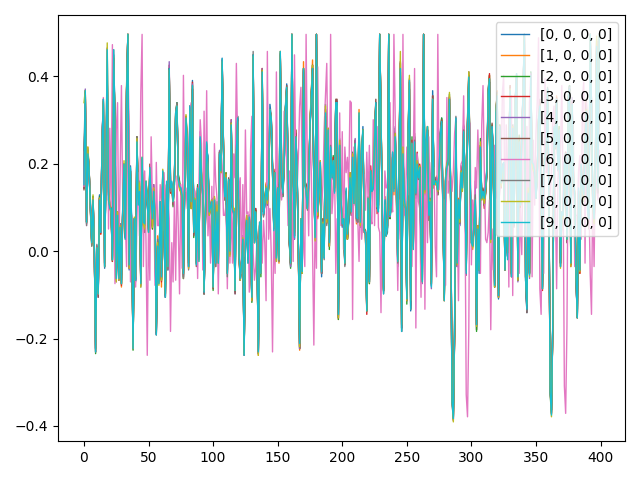

In [1]:
from utils_scale import utils_pins
%matplotlib widget
import matplotlib.pyplot as plt

# the passwords that we want to test
tries = [
    bytearray([0,0,0,0]),
    bytearray([1,0,0,0]),
    bytearray([2,0,0,0]),
    bytearray([3,0,0,0]),
    bytearray([4,0,0,0]),
    bytearray([5,0,0,0]),
    bytearray([6,0,0,0]),
    bytearray([7,0,0,0]),
    bytearray([8,0,0,0]),
    bytearray([9,0,0,0]),
]

# Get power traces (we use pre-recorded traces here)
traces = utils_pins.acquire_traces1(tries)

# Plot the power traces and corresponding passwords
# CAUTION: the traces are plotted on top of each other, therefore a trace that is identical
# to another one might be hidden.
utils_pins.plot_pins_traces(traces, tries)

As we can see, one power trace, the pink power trace (corresponding to the PIN `6000`) is more delayed than all others and appears shifted. Hence, the first character of the password was guessed correctly and the verification fails later at the second character. Using this information, we can essentially test all the characters individually and thus significantly reduce the effort for breaking the password.

## Attacking Real Password Authentication: your turn

Now that you have some intuition about how we can recover information using basic timing information, you are invited to repeat the previous attack and try to recover an unknown 4-digit (0-9) password. You can use the code provided in the next cell as a template for implementing your attack. While you can easily recover the code using manual modification together with visual inspection, don't hesitate to write the attack in an automated manner if you feel it! :) 

- *hint: Use the procedure that has just been seen above. Did you found the correct n-th digit? Good! Try to adapt `tries` to find out the (n+1)-th digit.*
- *hint2: the initial list of tries can be written as `tries=[bytearray([i,0,0,0]) for i in range(10)]`*

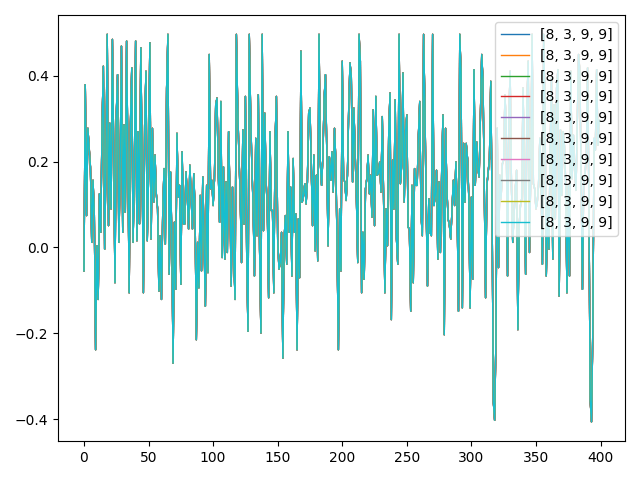

In [2]:
# the passwords that we want to test
# TODO: adapt for second, third and fourth digit.
# the passwords that we want to test
tries = [
    bytearray([0,0,0,0]),
    bytearray([1,0,0,0]),
    bytearray([2,0,0,0]),
    bytearray([3,0,0,0]),
    bytearray([4,0,0,0]),
    bytearray([5,0,0,0]),
    bytearray([6,0,0,0]),
    bytearray([7,0,0,0]),
    bytearray([8,0,0,0]),
    bytearray([9,0,0,0]),
]

###ANSWER_START
tries = [bytearray([8,3,9,9])  for i in range(10)]
###ANSWER_STOP

# get power traces
traces = utils_pins.acquire_traces2(tries)

# plot the power traces and corresponding passwords
utils_pins.plot_pins_traces(traces, tries)

You think you found the correct PIN? Check if you guess is correct by running the following code! 

In [3]:
my_pin_guess = bytearray([8,3,9,9]) # TODO: insert you guess here
utils_pins.verify_pin(my_pin_guess)

CONGRATS! You found it.


##  Attacking Constant-Time Password Authentication

In the previous examples we have seen that non-constant time behaviour of code can be easily exploited using power side-channels. 

It turns out that can rewrite the code such that the previous attack is **not applicable immediately** anymore:
```C
uint8_t pw[] = {6,7,8,9};

uint8_t diff = 0;
for (size_t i = 0; i < 4; i++){
    diff |= data[i] ^ pw[i];
}
```
The idea here is to modify the operation flow such that, no matter which password you enter and how many digits are correct, four loop iterations will always be performed. Here, the PIN is considered as valid if at the end of the loop `diff==0`. 

You can verify this for yourself using the following python scripts:

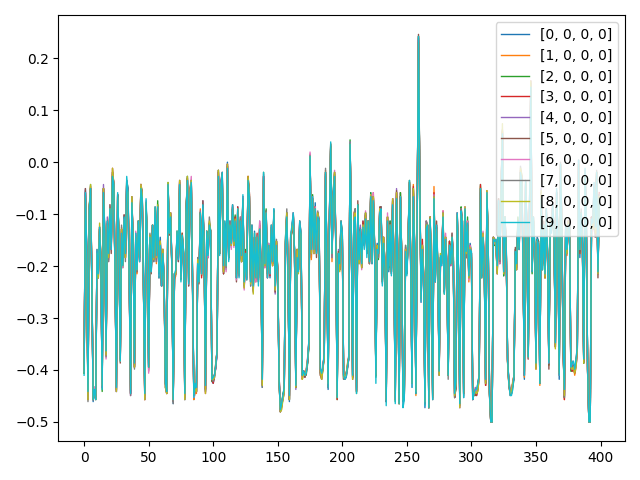

In [4]:
# the passwords that we want to test
tries = [
    bytearray([0,0,0,0]),
    bytearray([1,0,0,0]),
    bytearray([2,0,0,0]),
    bytearray([3,0,0,0]),
    bytearray([4,0,0,0]),
    bytearray([5,0,0,0]),
    bytearray([6,0,0,0]),
    bytearray([7,0,0,0]),
    bytearray([8,0,0,0]),
    bytearray([9,0,0,0]),
]

# Get power traces (we use pre-recorded traces here)
traces = utils_pins.acquire_traces3(tries)

# Plot the power traces and corresponding passwords
utils_pins.plot_pins_traces(traces, tries)

You should now see that all power traces are nicely aligned, no matter if a correct password was used or not. In other words, this code runs in constant time and uses a constant instruction sequence.

One particularly interesting feature of the power side-channel is that it can exploit more than just timing information. In the following of the training, we will exploit dependencies between the measurement and concrete data values that are being processed by a code that is completely constant-time.

## SCALE-I target and AES dataset description
In the following exercises, you will work with practical measurements from an AES software implementation acquired from a Cortex-M4 target on a ChipWhisperer 308 evaluation board. The implementation uses a look-up table for the S-box layer. The measurements were taken using a Tektronix [CT1](https://www.tek.com/en/datasheet/current-probe/ct1-ct2-ct6) current probe with a [PICO5000D](https://www.picotech.com/oscilloscope/5000/flexible-resolution-oscilloscope?kit=5242D) oscilloscope with a sampling frequency of 62.5 MHz.

The training dataset can be found [here](https://enigma.elen.ucl.ac.be/dsm/sharing/VMx9J3Xkc) and contains several directories, with each directory containing the traces and the associated metadata of a single dataset (i.e., a dataset that has been acquired under a specific configuration). From the names, you can already see that different configuration exist. You don't have to matter about that for the moment: the tutorials will provide further information about these and guide you on which one to use when required. However, for completeness, we summarize each dataset next (but don't hesitate to skip to the next paragraph at this point):

+ `training0`: contains traces collected using plaintexts and keys randomly generated for each trace. Such a dataset is typically used for training purpose. 
+ `validation*`: contains traces collected using using random plaintexts with the same fixed key (randomly generated) for each dataset. Knowing the key value used, these datasets are typically employed to assess the quality of a side-channel attack (validation purpose).
+ `ttest-kf`: contains traces collected using the same key and a randomly generated plaintext for each trace. 
+ `ttest-pf`: contains traces collected using the same plaintext and a randomly generated key for each trace. 

Each dataset consists in a single file `data.npz`, that is a [NumPy archive](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) file containing the following fields organized as 2D numpy arrays:

+ `traces`
    - int16 $\left[ nexec \times ns \right]$: collected traces for the $nexec$ executions measured. Each traces is composed of $ns$ measures.
+ `pts`
    - int8 $\left[ nexec \times 16 \right]$: plaintext used for each execution.
+ `ks`
    - int8 $\left[ nexec \times 16 \right]$: key used for each execution.
+ `cts`
    - int8 $\left[ nexec \times 16 \right]$: ciphertext used for each execution.

In practice, an adversary does not have access to the key when mounting an attack in a real-world setting. Nevertheless, as part of this training course, we are conducting a worst-case analysis of an implementation's security. Therefore, we provide the evaluator with all the necessary information to assess the best possible attack.

## Get your hands dirty: how to use the datasets with Python

The following code snippet provides an example of how to use the dataset files, typically to load the measured traces or the associated metadata. To run it, you need to adjust the value of the variable `filepath` to the location of the file you want to load on your computer. Try running it to see what a power trace looks like! 

In [5]:
# Load the usefull packages
import numpy as np  
from utils_scale import test_scale, utils_files, utils_plot
%matplotlib widget
import matplotlib.pyplot as plt

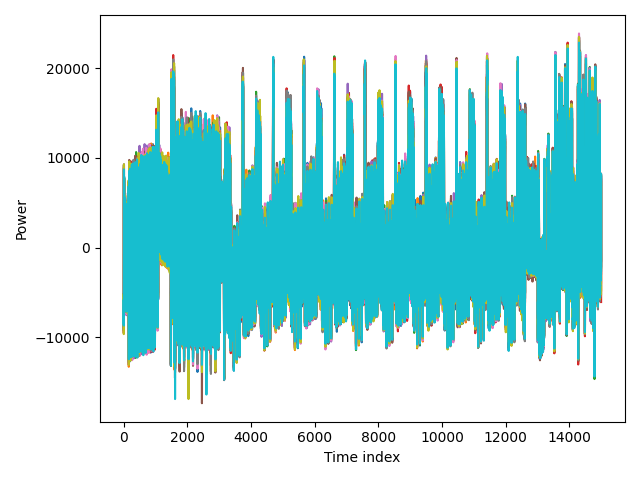

In [6]:
# Here, the variable `filepath` containes the path to the `.npz` file from which
# you want to load the data. The path provided should be relative to the location of this notebook on your computer.
filepath = "scale-dataset-25/training0/data.npz"

# Open to file and load all the data fields from it. 
# Here, 'dataset' is a dict with the keys 'traces', 'pts', 'ks' and 'cts', corresponding
# to the dataset fields.
dataset = utils_files.load_dataset(filepath)

# Create the figure and plot the first 10 loaded traces. 
# CAUTION: plotting a lot of traces simultaneously can lead to bad plotting performances ;) 
utils_plot.plot_traces(dataset['traces'][:10,])


And 'Voilà'! Isn't it beautiful? Don't hesitate to explore a bit the figure by zooming in! 

As already mentioned, you can see that even if the plotted traces correspond to executions with different inputs, they are properly aligned (and no timing side-channel can be exploited). However, a quick visual inspection can already provide information about the running algorithm: we can observe repetitive patterns! Although we've already said that it's AES-128, this kind of information can be useful to retrieve information about the algorithm used, or to know where to look when long measurements are acquired without any particular details related to time when cryptographic operation are performed. 

Try yourself! What kind(s) of patterns do you observe? How many are they? What operations do you expect to be carried out in the different areas of the measure? In particular:
- where are the different rounds computed? How do they decompose?
- where are the round key computed?


*hint: the [AES-128](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard#High-level_description_of_the_algorithm) consists in performing the repetition of 9 rounds composed of the same operations (i.e., SubByte, ShiftRows, MixColumns, AddRoundKey) and a final round without the MixColumns operation*

## Fixed-input traces behavior
As described above, the measured implementation is carried out in such a way that no timing side-channel can be used. However, we will see that other dependencies can be exploited. To give you a little more intuition, let's look a little more closely at what can be observed when we analyse the measurements obtained. 

Lets start easy by looking at the traces that have been aquired for a fixed plaintext-key pair. That is, we consider a dataset for which all the traces contained have been acquired by measuring indepentant executions that were using the same pair of plaintext and key, denoted next ($p_0$;$k_0$). The following piece of code load such a dataset and displays some statistic about the dataset (don't hesitate to check it out by yourself by displaying manually the data used for each execution). 


In [26]:
from utils_scale import utils_obs

# Load the dataset that is using fixed plaintext and key for each traces.
dataset = utils_obs.load_dataset_p0k0()

# Compute the amount of different plaintexts, keys and resulting ciphertext used in the dataset
am_pts = len(np.unique(dataset["pts"],axis=0))
am_ks = len(np.unique(dataset["ks"],axis=0))
am_cts = len(np.unique(dataset["cts"],axis=0))

# Display some statistic
print(f"{am_pts} different plaintext(s) identified")
print(f"{am_ks} different keys(s) identified")
print(f"{am_cts} different ciphertext(s) identified")


1 different plaintext(s) identified
1 different keys(s) identified
1 different ciphertext(s) identified


Next, we display some traces of the loaded dataset. Bearing in mind that all the calculations carried out during the different executions are exactly the same (as explained above), what would you expect from the behaviour of the measurements? Is this satisfied in practice? 

- *hint: If the same plaintext-key pair is used by multiple independent executions, the exact same computation are performed during these executions.*
- *hint2: the acquisition setup stays the same when performing the differents measurements.*

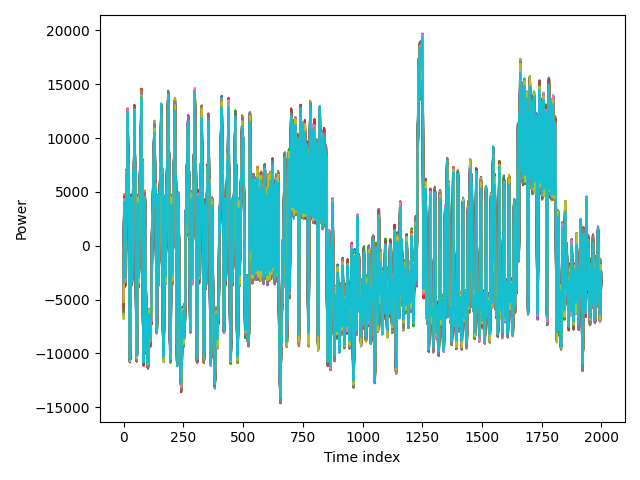

In [27]:
from utils_scale import utils_obs
dataset = utils_obs.load_dataset_p0k0()

# Amount of traces to display
t2disp=100
# Here, we only plot the sample in a specific window. 
# You can use 
start_idx = 2500
end_idx = 4500

utils_plot.plot_traces(dataset["traces"][:t2disp,start_idx:end_idx])

The variations observed in the measurements represent a significant non-ideality when we try to characterise the leakage associated with fixed data. These are more commonly known as ‘noise’ and will be discussed in more detail later in the training. To make it easier to interpret what we observe in the measurements, we can try to derive the average behaviour of the measurements when they are associated with a given value, which in our case is the plaintext-key pair $p_0$-$k_0$. To do this, you are asked to implement the following function to compute the mean of a given set of traces:

- *hint: [NumPy](https://numpy.org/doc/2.2/reference/generated/numpy.mean.html) implements a lot of useful operations on 2-D arrays.*

In [9]:
# TODO: implement the following function
def traces_mean(traces):
    """
    Compute the mean of a set of traces

    traces: an NumPy array of shape (ntraces, nsamples)

    Returns: the average trace, as a NumPy array of shape (nsamples,)
    """
    ###ANSWER_START
    return np.mean(traces,axis=0)
    ###ANSWER_STOP

Once implemented, you can verify you function here:

In [10]:
from utils_scale import test_scale
test_scale.test_mean(traces_mean)

Good job! Your implementation seems correct :)


Now, complete the next cell in order to display the average trace associated to the pair ($p_0$;$k_0$):

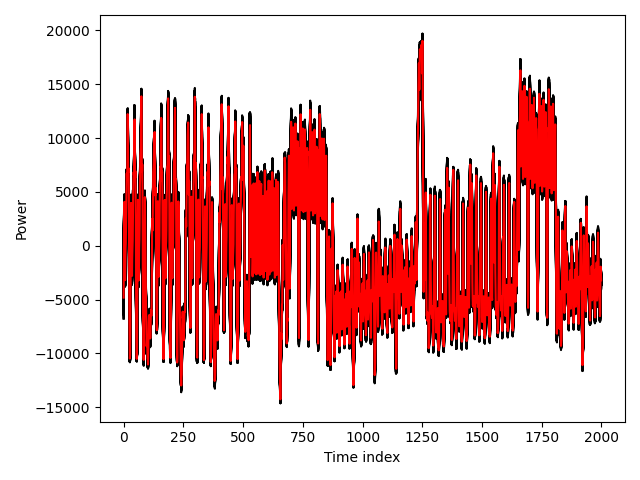

In [11]:
from utils_scale import utils_obs
dataset = utils_obs.load_dataset_p0k0()

avg_trace = None #TODO: complete here
###ANSWER_START
avg_trace = traces_mean(dataset["traces"])
###ANSWER_STOP

# Display some original traces in black, and the computed average trace in red
start_idx = 2500
end_idx = 4500
hfig = utils_plot.plot_traces(dataset["traces"][:100,start_idx:end_idx],color="black",hold=True)
utils_plot.plot_traces(avg_trace[start_idx:end_idx],color="red",hfig=hfig)

So far, we've focused on the behavior of measurements when the device is operating with a single pair of plaintext-clicks. In particular, we have observed that independent measurements of the same operation are prone to variations, and that the impact of these variations can be reduced by averaging the traces associated with the same manipulated value (these traces are said to belong to the same class).  Next, we'll see how this behavior evolves when different data are manipulated.

## Variable-plaintext traces observation

Next, we consider two different datasets that have been acquired with fixed plaintext-key pair:
- `dataset1` that uses ($p_0$;$k_0$), and is the same as the one used on the previous exercise,
- `dataset2` that uses ($p_1$;$k_0$), and therefore uses the same key as `dataset1`, but uses a different plaintext.

Try to use the following code the means of the two dataset. What do you observe? 

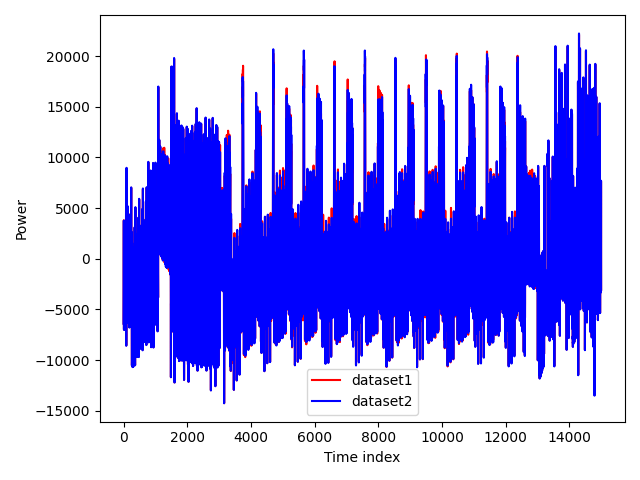

In [12]:
from utils_scale import utils_obs
dataset1 = utils_obs.load_dataset_p0k0()
dataset2 = utils_obs.load_dataset_p1k0()

# Mean of datasets
mean_dataset1 = traces_mean(dataset1['traces'])
mean_dataset2 = traces_mean(dataset2['traces'])

# Plot the means
hfig = utils_plot.plot_traces(mean_dataset1,color="red",hold=True, label="dataset1")
utils_plot.plot_traces(mean_dataset2,color="blue",hfig=hfig, label="dataset2")

In order to highlight your observations, an alternative is to compute the distance between the datasets averaged traces. To do so, you have to implement to following function

- *hint: NumPy implements [classical operators](https://numpy.org/doc/2.2/reference/arrays.ndarray.html#arithmetic-matrix-multiplication-and-comparison-operations)  for arithmetic operations*
- *hint2: Don't forget to check that the operation you're trying to do isn't already implemented in [Numpy](https://numpy.org/doc/stable/reference/routines.math.html#mathematical-functions)*

In [13]:
#TODO implement
def dist(v0, v1):
    """
    Compute the element-wise distance between two vectors of same length

    v0, v1 are two NumPy array of shape (nsamples,)
    Returns: a NumPy array of shape (nsamples,) containing the element-wize distance between v0 and v1.
    """
    ###ANSWER_START
    return np.sqrt((v0-v1)**2)
    ###ANSWER_STOP

You can test your function here.

In [14]:
from utils_scale import test_scale
test_scale.test_dist(dist)

Good job! Your implementation seems correct :)


Now, try to adapt the following template in order to plot the distance between the averaged traces of the two dataset. What do you observe? 

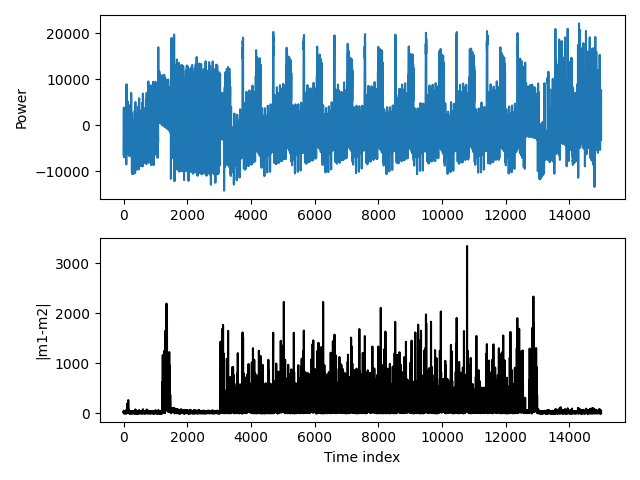

In [15]:
from utils_scale import utils_obs
dataset1 = utils_obs.load_dataset_p0k0()
dataset2 = utils_obs.load_dataset_p1k0()

# TODO: complete here
dist_avg = None
###ANSWER_START
mean_dataset1 = traces_mean(dataset1['traces'])
mean_dataset2 = traces_mean(dataset2['traces'])
dist_avg = dist(mean_dataset1, mean_dataset2)
###ANSWER_STOP

# Generate a figure with two subplots:
# - an examplary trace (to ease temporal visualization)
# - the metric to plot (the distance computed in our case)
utils_plot.plot_metric(mean_dataset1,dist_avg, "|m1-m2|")

The observed dependencies between the data processed by the devices and the correpsonding traces can be used to obtain information about the plaintext that was used, just by observing the measurements. The following exercise illustrates this: your aim is to re-identify to which dataset (between dataset1 and dataset2) a set of measurements belongs. You can use the following template to help you.

## Exercice: re-identify the plaintext

In this exercise, you will obtain a set of traces that have been measured with the key $k_0$ and either with $p_0$ or $p_1$ as plaintext. Your aim is to re-identify for each trace the plaintext used (between $p_0$ and $p_1$). The following template is a good basis for displaying the different test traces, as well as the average traces obtained for the datasets and can help you in finding the solution. 
- *hint: The means of `dataset1` and `dataset2` can be used as reference for re-identification*
- *hint2: It may be useful to consider only a small area of the traces which features a large difference of means to facilitate re-identification.*

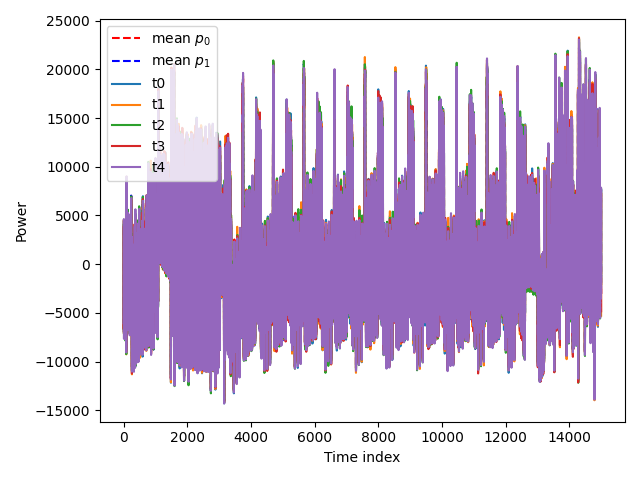

In [35]:
import numpy as np
from utils_scale import utils_obs

## Specify the window in the traces
# TODO: 
start = 0
end = 15000

## Here, we compute the means of the two reference datasets, each containing traces associated to one or the other case considered in the exercice. 
dataset1 = utils_obs.load_dataset_p0k0()
dataset2 = utils_obs.load_dataset_p1k0()

mean_dataset1 = traces_mean(dataset1['traces'][:,start:end])
mean_dataset2 = traces_mean(dataset2['traces'][:,start:end])

# Plot the mean traces of each dataset (in dashed line)
hfig = utils_plot.plot_traces(mean_dataset1,color="red",hold=True, label=r"mean $p_0$", linestyle="dashed")
hfig = utils_plot.plot_traces(mean_dataset2,color="blue",hold=True, hfig=hfig, label=r"mean $p_1$", linestyle="dashed")

## Second, we load the traces to re-identify, and plot them
test_traces = utils_obs.load_traces_eid1()[:,start:end]

# Flag to indicate if you want to plot or not the test traces
# TODO: you can disable the plot of a test trace by setting '0' instead of '1' here.
f2plot = [1,1,1,1,1] 


for (i,flag) in zip(range(len(test_traces)),f2plot):
    if flag:
        if sum(f2plot[i+1:])==0:
            utils_plot.plot_traces(test_traces[i],hfig=hfig, label=f"t{i}")
        else:
            hfig = utils_plot.plot_traces(test_traces[i],hold=True, hfig=hfig, label=f"t{i}")



Once you believe you found to which plaintext each trace of `test_traces` correpsond, you can verify your guess with the following piece of code

In [34]:
from utils_scale import utils_obs
# TODO: edit the following list in order to encode which plaintext you believe was used for each traces.
# In particular, `plaintext_id[i]` depicts the plaintext used for the i-th trace of test_traces. Two values are possible
# '0': if you believe that the plaintext p0 was used.
# '1': if you beleive that the plaintext p1 was used. 
plaintext_id = [0,1,1,0,0]
utils_obs.verify_eid1(plaintext_id)

Your guess is as follows:
t0 corresponds to p0
t1 corresponds to p1
t2 corresponds to p1
t3 corresponds to p0
t4 corresponds to p0
Good job! :)


## Variable-key traces observation
So far, we've looked at what happens when we consider 2 distinct plaintexts and the same key. The question is whether similar behavior can be observed in a complementary case where two distinct keys are used with the same plaintext. To this end, we consider a case study using the following two datasets:

- `dataset1` that uses ($p_0$;$k_0$), and is the same as the one used on the previous exercises,
- `dataset3` that uses ($p_0$;$k_1$), and therefore uses the same plaintext as `dataset1`, but uses a different key.

The following piece of code has been adapted from the previous example in order to display the distance of averaged trace in such a setting. How does it compare to the case using a fixed key? How do you explain it?

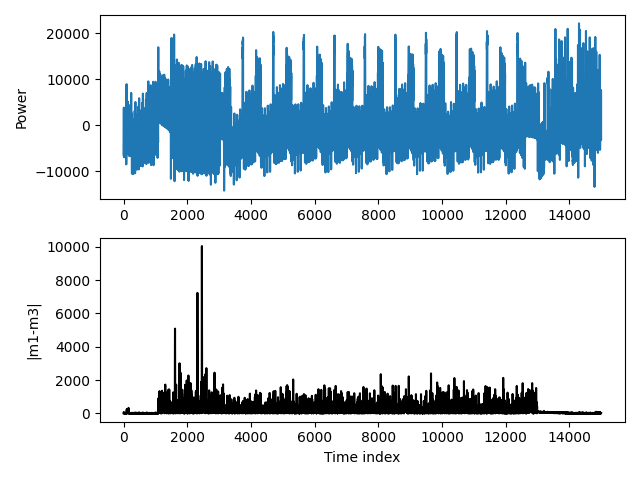

In [18]:
from utils_scale import utils_obs
dataset1 = utils_obs.load_dataset_p0k0()
dataset3 = utils_obs.load_dataset_p0k1()

mean_dataset1 = traces_mean(dataset1['traces'])
mean_dataset3 = traces_mean(dataset3['traces'])
dist_avg = dist(mean_dataset1, mean_dataset3)

# Plot the metric
utils_plot.plot_metric(mean_dataset1,dist_avg, "|m1-m3|")

## Entering the rabbit hole: traces observations with specific intermediate states. 
Let's go into a little more detail about the algorithm and look at the dependencies that might exist with intermediate values manipulated by the device being measured. In particular, we'll be more specific and analyze the behavior of traces that correspond to a specific internal value. 

To do this, we need to be able to filter traces according to the class to which they belong. As a reminder, traces are said to belong to the same class if they correspond to an execution that manipulates the same intermediate value of interest. In the previous exercises, we considered two classes: the class were assigned to their class depending either on two different plaintext values, either on two different key values. 
Here, we're going to use the output of a single Sbox (out of 16) in the first AES round as the internal value of interest. The value of the latter will acts as the traces discriminating feature, and we will thus have 256 different classes possible. 

To move forward smoothly, your first task is to compute the value obtained at Sbox output in the first round of AES when specific plaintext-key pair are used. To do so, you have to implement the function `compute_sbox_output` defined next. 


In [19]:
# Load the AES Sbox utils. 
# Here, Sbox is a NumPy array of 256 elements, such that Sbox[i]=SubBytes(i).
from utils_scale.utils_aes import Sbox 

#TODO: implement the function
def compute_sbox_output(pts, ks):
    """
    Compute the results of the AES first round SubBytes layer for the provided
    plaintext and key. 

    pts: a NumPy array of shape (nexec, 16), where each row is a plaintext
    ks: a NumPy array of shape (nexec, 16), where each row is a key

    Indexing pts[i,:] and ks[i,:] corresponds to the i-th plaintext-key pair. 

    returns: a NumPy array of shape (nexec, 16), 
    """
    ###ANSWER_START
    return Sbox[pts ^ ks]
    ###ANSWER_STOP

You can verify your function here:

In [20]:
from utils_scale import test_scale
test_scale.test_sbox_output(compute_sbox_output)

Good job! Your implementation seems correct :)


For you second task, you have to use the value of a specific byte at the Sbox in order to filter the corresponding set of traces. Please implement the function describded in the next cell. 

- *NB: While you can directly rely on the function `compute_sbox_output`, it may result in sub-optimal performances since it performs unecessary computation (i.e., it compute the Sbox results for all the bytes instead of the one targeted. Don't hesitate to write dedicated code for the function `filter_traces_sbox_output`.*

In [21]:
# TODO: implement the function
def filter_traces_sbox_output(traces, pts, ks, bindex, bvalue):
    """ 
    Returns the subset of traces such that the value 
    of the ‘bindex’-th byte at Sbox output is equal to 'bvalue' in the first round.

    traces: the traces, as a NumPy array of shape (nexec, nsamples)
    pts: the plaintext associated to the traces, as a NumPy array of shape (nexec, 16)
    ks: the key associated to the traces, as a NumPy array of shape (nexec, 16)
    
    """
    ###ANSWER_START
    # Compute the intermediate state of interest, using ONLY the target byte.
    intermediate = Sbox[pts[:,bindex] ^ ks[:,bindex]]
    # Return the traces at indexes that correspond to the filtering condition
    return traces[intermediate==bvalue,:]
    ###ANSWER_STOP


You can verify your function here:

In [22]:
from utils_scale import test_scale
test_scale.test_filter_traces_sbox_output(filter_traces_sbox_output)

Good job! Your implementation seems correct :)


As a final step, the following code template mixes the previous steps and allows you to observe the distance between the average traces associated to two different values taken by a single byte at the output of the SBox. More particularly, you can adjust the following parameters:

- `bindex`: in the range \[0;15\], allows you to select which byte to consider after the Sbox,
- `bitsv0`: the first value used in the comparison, encoded as an array of 8 binary values
- `bitsv1`: the second value used in the comparison, encoded as an array of 8 binary values

In a similar way to what you had done with only two different plaintexts or keys, what can you observe for distinct values taken by the targeted byte? In particular:

- Do you observe different behavior when different values are used?
- Is the distance peak observed localized in the trace? Is it expected?
- How does its position evolve as a function of parameters?
- (Bonus: What a priori information on the precise order of operations carried out by the AES does this tell us?)

*hint: Which AES operation is performed at this location? Does it evolve with `bindex`? Dont hesitate to adjust the displaying window parameter `start` and `end` to zoom on the region of interest*

  
- Are there value pairs that lead to greater differences in behavior?

*hint: try to modify the values of `bitsv0` and `bitsv1`*.








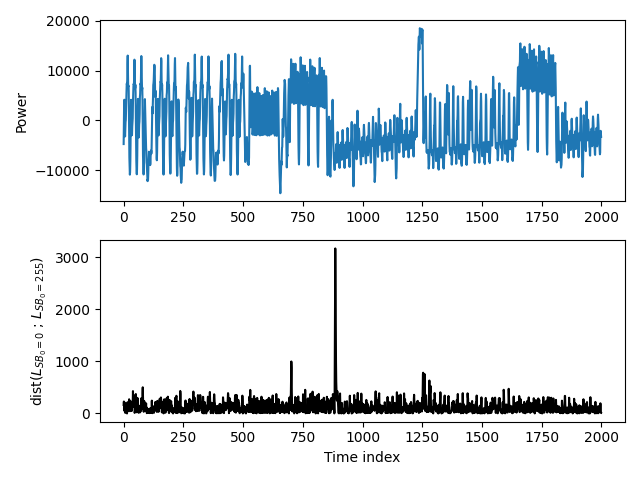

In [23]:
from utils_scale import utils_obs

# Load the dataset used in the exercice
dataset = utils_obs.load_dataset_all_random()

# Analysis parameter
#TODO: identify the impact of this parameter
bindex = 0 # Index of the Sbox output to target, in [0;15]

#TODO: identify the impact of these parameters
# The two values that we want to compare. These are encoded as binary words with little endian encoding.
bitsv0=[0,0,0,0,0,0,0,0] # by default equals to 0x00
bitsv1=[1,1,1,1,1,1,1,1] # byt default equals to 0xff

# Temporal window of interest
start = 2500
end = 4500

# Compute the mean of the traces subset.
bvalue0 = utils_obs.bvalue_from_bits(bitsv0)
bvalue1 = utils_obs.bvalue_from_bits(bitsv1)
m0 = traces_mean(filter_traces_sbox_output(dataset["traces"][:,start:end],dataset["pts"],dataset["ks"],bindex,bvalue0))
m1 = traces_mean(filter_traces_sbox_output(dataset["traces"][:,start:end],dataset["pts"],dataset["ks"],bindex,bvalue1))

# Compute the dist
dist_m0_m1 = dist(m0,m1)

# Plot the result

utils_plot.plot_metric(m0,dist_m0_m1, r'dist($L_{{SB_{}={}}}$ ; $ L_{{SB_{}={}}}$)'.format(bindex,bvalue0,bindex,bvalue1))


## Exercice: re-identify the value of the Sbox for a single byte. 
The next exercise is a more complicated variant of the one you did, in which you had to re-identify the plaintext based on the observation of tracks. In particular, your aim is to re-identify which Sbox output value has been manipulated by the device (among only the values 0, 1, 2 and 3) based on observation of the trace. In the context of this exercise, we are only interested in the output of the first Sbox (i.e. `bindex`=0). In the same way as above, the following template lets you observe the average trace associated with each class and display the desired test traces. In order to help you, we already configured a time window corresponding to the area of the trace where the distance between the class means was big.

Try to re-identify to which class belong each class!

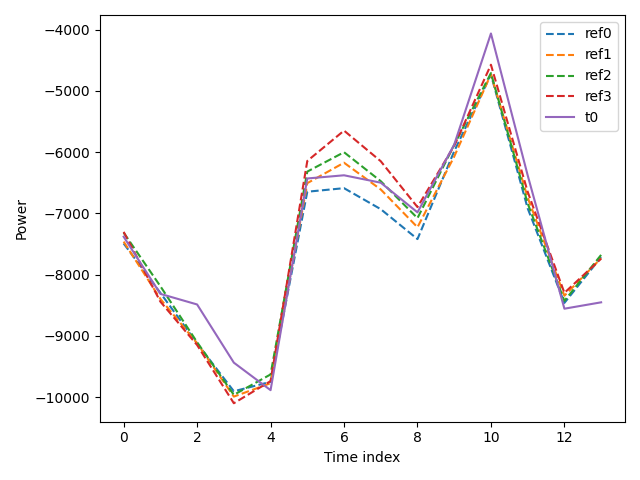

In [24]:
from utils_scale import utils_obs, utils_plot

# window to consider. 
start=3380
end = 3394

# Load the traces to re-identify
test_traces, values_candidate, bindex= utils_obs.load_traces_eid2()
test_traces=test_traces[:,start:end]

# Compute the references for the possibles labels
dataset = utils_obs.load_dataset_all_random()
ds = [filter_traces_sbox_output(dataset["traces"][:,start:end],dataset["pts"],dataset["ks"],bindex,bv) for bv  in values_candidate]
mvs = [traces_mean(trs) for trs in ds]

# Plot the mean trace associated to each class
hfig=None
for i,t in enumerate(mvs):
    if i==len(values_candidate)-1:
        hfig = utils_plot.plot_traces(t,hfig=hfig, hold=True, label=f"ref{values_candidate[i]}", linestyle="dashed")
    else:
        hfig = utils_plot.plot_traces(t,hold=True, hfig=hfig, label=f"ref{values_candidate[i]}", linestyle="dashed")

# Flag to indicate if you want to plot or not the test traces
# TODO: you can disable the plot of a test trace by setting '0' instead of '1' here.
f2plot = [1,0,0,0,0] 

for (i,flag) in zip(range(len(test_traces)),f2plot):
    if flag:
        if sum(f2plot[i+1:])==0:
            utils_plot.plot_traces(test_traces[i],hfig=hfig, label=f"t{i}")
        else:
            hfig = utils_plot.plot_traces(test_traces[i],hold=True, hfig=hfig, label=f"t{i}")


Once you believe you found to which class each trace of `test_traces` corresponds, you can verify your guess with the following piece of code

In [25]:
from utils_scale import utils_obs
# TODO: edit the following list in order to encode which plaintext you believe was used for each traces.
# In particular, `plaintext_id[i]` depicts the plaintext used for the i-th trace of test_traces. The possible values are in [0,1,2,3]
class_id = [0,0,0,0,0]
utils_obs.verify_eid2(class_id)

Your guess is as follows:
t0 corresponds to the class 0
t1 corresponds to the class 0
t2 corresponds to the class 0
t3 corresponds to the class 0
t4 corresponds to the class 0
Sadly, you did not succeeded in the plaintexts used correctly.


As you will have realised, visual analysis is possible in certain situations, but its limits are quickly reached. In particular, this last exercise shows that it quickly becomes difficult when the different classes have a behaviour that is difficult to distinguish, which appears when they have close leakage values and which is amplified by the impact of noise. In the rest of the training, we'll be looking at more advanced statistical tools, which will enable us to exploit the information in a finer grain way.